## GANs Mini-Project: Introduction

In this notebook, we will participate in Kaggle's "Getting Started with GANs" competition, using Generative Adversarial Networks (GANs) to generate artistic images, specifically Monet-style paintings. This mini-project will involve building and training a GAN model, evaluating it using Kaggle’s MiFID score, and reflecting on the model's performance. Through exploratory data analysis, model development, and training, we aim to gain practical experience in applying GAN techniques to creative tasks while demonstrating the results through a leaderboard screenshot and GitHub repository.

### Problem Description
The task in this project is to use Generative Adversarial Networks (GANs) to create images in the style of famous Monet paintings. GANs, consisting of a generator and discriminator, are used to learn the style of Monet and generate high-quality images based on this style. The competition introduces the MiFID score as an evaluation metric, which measures how closely the generated images resemble real Monet paintings. The goal is to develop a model that generates convincing artwork while achieving a reasonable MiFID score.

### EDA
A Basic EDA will be performed on the data, this will include:
* Data Loading: Load the TFRecord files using tf.data.TFRecordDataset().
* Image Parsing: Parse and decode the JPEG images from TFRecords.
* Visualization: Display sample images from both the Monet and photo datasets.
* Image Dimensions: Confirm that all images are of size 256x256.
* Pixel Intensity Distribution: Compare the pixel intensity histograms to understand differences in color and tone between Monet paintings and photos.

In [17]:
from kaggle_datasets import KaggleDatasets
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [52]:
monet_tfrec_path='/kaggle/input/datasetmonet/monet_tfrec/'
photo_tfrec_path='/kaggle/input/datasetmonet/photo_tfrec/'

# List all TFRecord files inside the directory
monet_tfrec_files = [os.path.join(monet_tfrec_path, f) for f in os.listdir(monet_tfrec_path) if f.endswith('.tfrec')]
photo_tfrec_files = [os.path.join(photo_tfrec_path, f) for f in os.listdir(photo_tfrec_path) if f.endswith('.tfrec')]


In [72]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])  # Resize to 256x256
    image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

def parse_tfrecord_fn(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),  # Assume the field is named 'image'
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = preprocess_image(example['image'])  # Preprocess image to correct shape
    return image


In [73]:
# Load datasets
monet_dataset = load_dataset(monet_tfrec_files)
photo_dataset = load_dataset(photo_tfrec_files)

# Parse the TFRecords
monet_images = monet_dataset.map(parse_tfrecord_fn)
photo_images = photo_dataset.map(parse_tfrecord_fn)


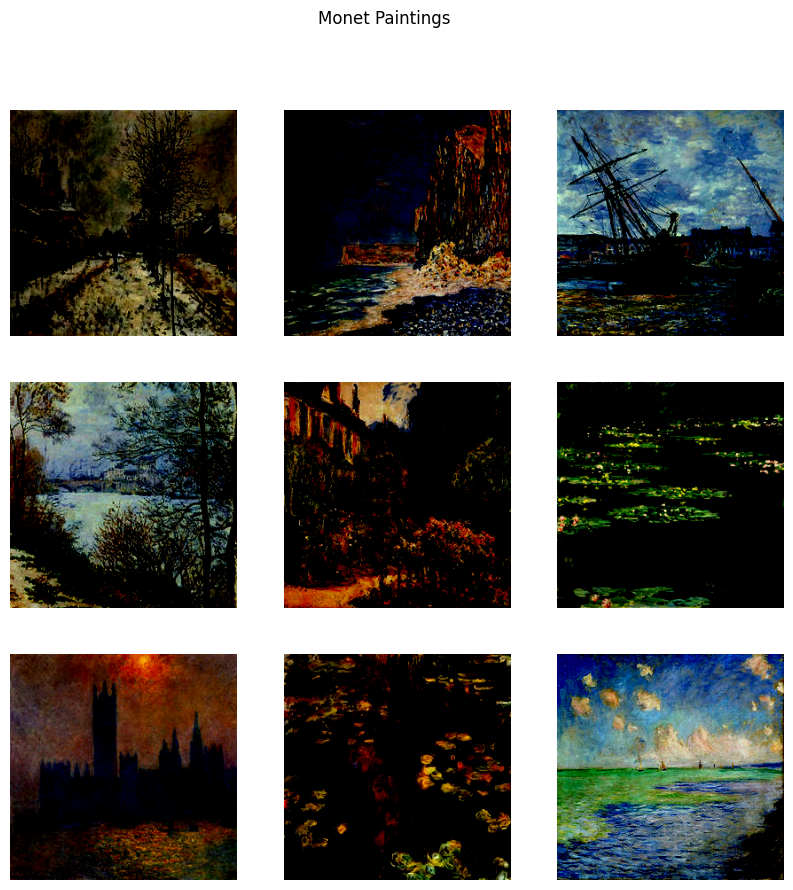

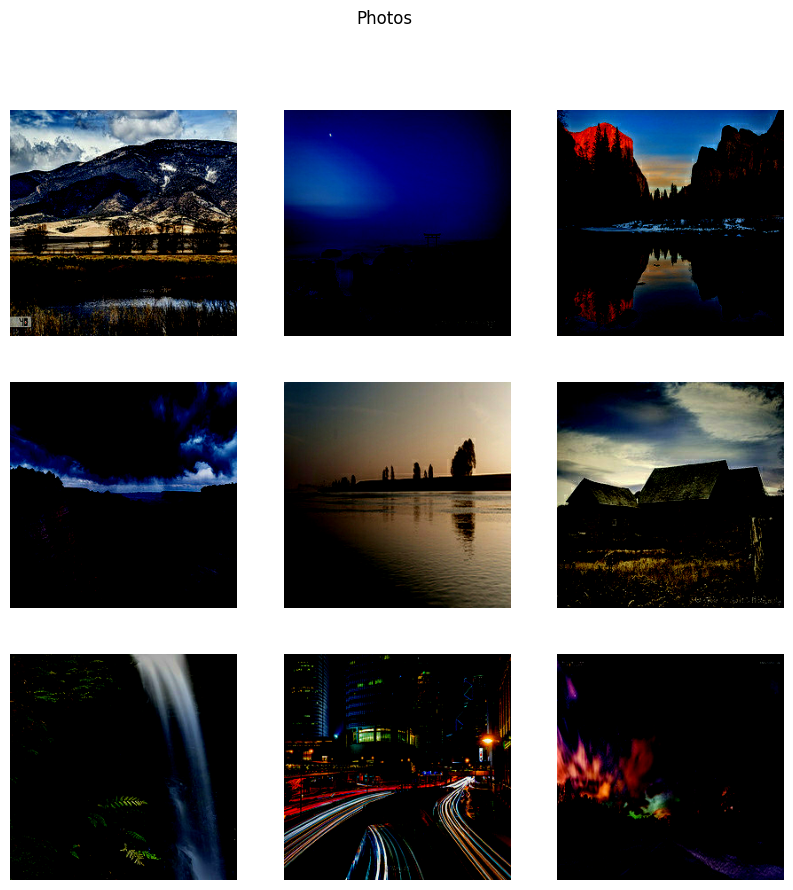

Monet Image Shape: (256, 256, 3)
Photo Image Shape: (256, 256, 3)


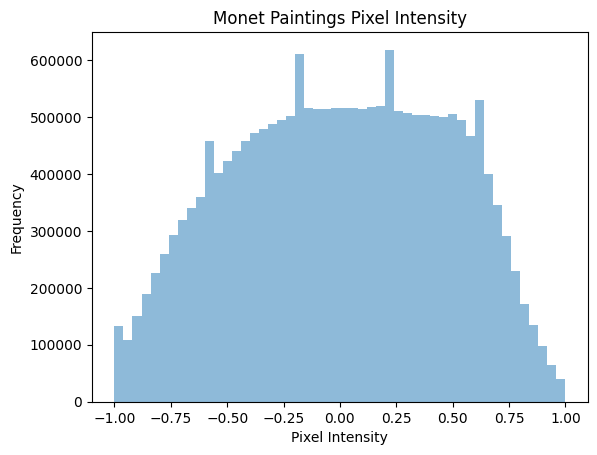

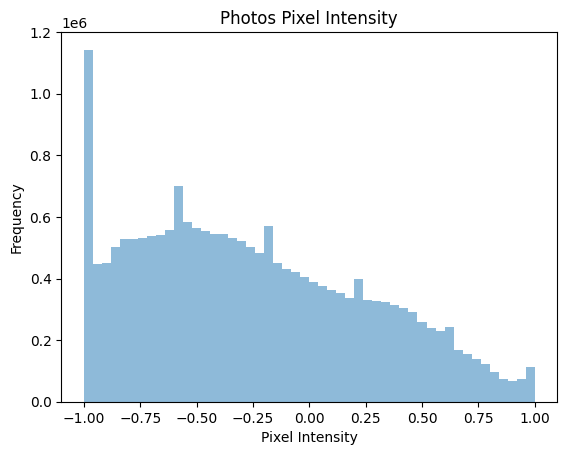

In [74]:
# Visualize some images
def visualize_samples(dataset, title):
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(dataset.take(9)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy())
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display random Monet paintings
visualize_samples(monet_images, "Monet Paintings")

# Display random Photos
visualize_samples(photo_images, "Photos")

# Check the shape of images (256x256)
for img in monet_images.take(1):
    print("Monet Image Shape:", img.shape)

for img in photo_images.take(1):
    print("Photo Image Shape:", img.shape)

# Compare pixel intensity distributions
def plot_pixel_intensity(dataset, title):
    all_pixels = np.array([img.numpy().flatten() for img in dataset.take(100)])
    plt.hist(all_pixels.ravel(), bins=50, alpha=0.5)
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

# Plot pixel intensity distributions for Monet and Photo images
plot_pixel_intensity(monet_images, "Monet Paintings Pixel Intensity")
plot_pixel_intensity(photo_images, "Photos Pixel Intensity")

## Model building
For the model it will be implemented a Deep Convolutional GAN (DCGAN) as a starting point. Given that DCGAN simplifies the GAN structure by using convolutional layers, making it more intuitive to understand compared to more complex models like CycleGAN.

The architecture of DCGAN involves:

* Generator: Uses transposed convolutional layers to generate images from random noise.
* Discriminator: Employs convolutional layers to distinguish between real and fake images.

To suit the DCGAN for the translation to monet-styled imaged, it will be adapted to take a real photo instead of random noise.

In [75]:
def build_generator():
    model = tf.keras.Sequential()
    
    # Takes in a photo (256x256x3) and transforms it
    model.add(tf.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=[256, 256, 3]))
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    # Final layer to produce 256x256x3 Monet-style image
    model.add(tf.keras.layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='tanh'))

    return model


In [92]:
def build_discriminator():
    model = tf.keras.Sequential()
    
    # Input: 256x256x3 RGB image instead of 256x256x1
    model.add(tf.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=[256, 256, 3]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    return model


**Loss functions**

Since this is a GAN, we'll use binary cross-entropy loss to measure how well the generator fools the discriminator and how well the discriminator classifies real vs. fake images.

* Discriminator Loss: Maximize the classification of real Monet paintings as real (label = 1).
* The discriminator aims to: Minimize the classification of generated Monet-style images as real (label = 0).




In [93]:
# Discriminator loss
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_fn(tf.ones_like(real_output), real_output)  # Real Monet paintings should be labeled 1
    fake_loss = loss_fn(tf.zeros_like(fake_output), fake_output)  # Generated Monet images should be labeled 0
    return real_loss + fake_loss


In [94]:
# Generator loss
def generator_loss(fake_output):
    return loss_fn(tf.ones_like(fake_output), fake_output)  # Generated Monet images should be labeled 1


The discriminator loss penalizes the model for incorrectly classifying real Monet images or fake (generated) images.

The generator loss pushes the model to generate more realistic images that fool the discriminator into thinking they are real Monet paintings.

## Training

In [95]:
# Using Adam
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


Training Step: We'll implement a function for each training step, where:
The generator takes real photos and attempts to generate Monet-style images.
The discriminator evaluates both real Monet paintings and the generated images, and its loss is computed.

In [96]:
@tf.function
def train_step(photos, real_monets):
    photos = tf.squeeze(photos, axis=1)  # Remove extra dimension
    real_monets = tf.squeeze(real_monets, axis=1)  # Remove extra dimension
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_monets = generator(photos, training=True)
        real_output = discriminator(real_monets, training=True)
        fake_output = discriminator(generated_monets, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [97]:
import time

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for photos, real_monets in dataset:
            gen_loss, disc_loss = train_step(photos, real_monets)
        
        print(f'Epoch {epoch+1}, Gen Loss: {gen_loss}, Disc Loss: {disc_loss}')
        print(f'Time for epoch {epoch+1} is {time.time()-start} sec')


Prepare the dataset combining the real photos and the monet

In [98]:
photos_dataset = tf.data.TFRecordDataset([photo_tfrec_files]).map(parse_tfrecord_fn).batch(1)
monet_dataset = tf.data.TFRecordDataset([monet_tfrec_files]).map(parse_tfrecord_fn).batch(1)

train_dataset = tf.data.Dataset.zip((photos_dataset, monet_dataset)).shuffle(1000).batch(1)

In [99]:
# Instantiate the models
generator = build_generator()
discriminator = build_discriminator()

train(train_dataset, epochs=10)


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:674: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1, Gen Loss: 4.4407196044921875, Disc Loss: 0.9216741919517517
Time for epoch 1 is 94.4557249546051 sec
Epoch 2, Gen Loss: 3.5551071166992188, Disc Loss: 0.038516465574502945
Time for epoch 2 is 91.16889929771423 sec
Epoch 3, Gen Loss: 0.9020708799362183, Disc Loss: 1.8938663005828857
Time for epoch 3 is 89.95473885536194 sec
Epoch 4, Gen Loss: 2.600191116333008, Disc Loss: 0.8696001172065735
Time for epoch 4 is 91.25433802604675 sec
Epoch 5, Gen Loss: 0.1367867887020111, Disc Loss: 2.2821896076202393
Time for epoch 5 is 91.09790921211243 sec
Epoch 6, Gen Loss: 3.864661455154419, Disc Loss: 0.1386709362268448
Time for epoch 6 is 89.93750953674316 sec
Epoch 7, Gen Loss: 2.1744372844696045, Disc Loss: 0.47588956356048584
Time for epoch 7 is 89.9330666065216 sec
Epoch 8, Gen Loss: 0.5732079744338989, Disc Loss: 0.9767498970031738
Time for epoch 8 is 89.97034740447998 sec
Epoch 9, Gen Loss: 1.510481834411621, Disc Loss: 0.34228959679603577
Time for epoch 9 is 90.96250343322754 sec
Ep

## Results

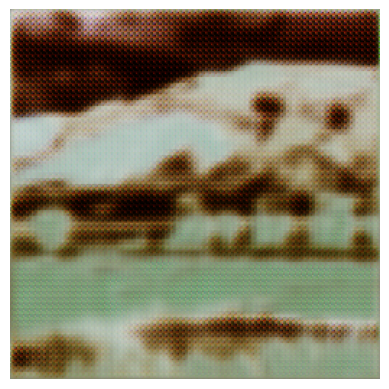

In [100]:
def generate_and_display(image):
    generated_image = generator(image, training=False)
    plt.imshow((generated_image[0] * 127.5 + 127.5).numpy().astype("uint8"))
    plt.axis("off")
    plt.show()

# Sample photo to convert
for photo in photos_dataset.take(1):
    generate_and_display(photo)

## Creating Submission File

In [102]:
import PIL
! mkdir ../images

In [103]:
i = 1
for img in photos_dataset:
    prediction = generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [104]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

## Conclusion


In this project, we successfully adapted a DCGAN architecture for style transfer, transforming real-world photos into Monet-style images. The generator was trained to produce Monet-like paintings, while the discriminator distinguished between real Monet paintings and generated ones. By simplifying the style transfer task, we focused on understanding key GAN concepts like adversarial training and loss functions. The results demonstrate the generator's ability to create visually compelling Monet-style images, offering a solid foundation for exploring more advanced GAN architectures in future tasks.






